In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df = mavenn.load_example_dataset('xylE')

In [3]:
data_df

,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11,x
0,training,0,0,0,0,0,0,0,0,0,0,0,3,AAACAATAGCATTGTTCTTATCAATTTTGGATAAGTATTATAATTA...
1,test,0,0,0,0,0,0,0,0,0,0,1,0,AAACAATAGTATCGTTTTTAGCTCATTTGGATAATTATTACAATTA...
2,test,0,0,0,0,0,0,0,0,0,0,0,1,AAACAATAGTATTGCTTTTATCAATTTAGGATAATTATCACAATTA...
3,training,0,0,0,0,0,0,0,0,0,0,0,5,AAACAATAGTATTGCTTTTATCAATTTAGGATAATTATCACGATTA...
4,training,0,0,0,0,0,0,0,0,0,0,0,2,AAACAATAGTATTGCTTTTATCATTTTTGGAAAATTAACACGATTA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847223,training,0,0,0,0,0,0,0,0,1,0,0,0,TTTCAATAGTCTTGTTTTTATCAATTTTGGATAATTATCACAATTT...
1847224,validation,0,0,0,0,0,0,0,0,0,0,1,0,TTTCACTAGAATTGTTTTTATCAATTGTGGATAATTTTCACAATTA...
1847225,training,0,0,0,0,0,0,0,0,0,0,1,0,TTTCACTAGAATTGTTTTTATCAATTGTGGATAATTTTCACAATTA...
1847226,validation,0,0,0,0,0,0,0,0,0,0,3,0,TTTCAGTAGTATGGTTTTTATCAATTTTGGATAATTATCACATTTA...


In [4]:
# # Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')

test N: 369,710
training + validation N: 1,477,518


In [5]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=150, Y=12


In [6]:
!ls 21.12.25.matrices

CRP_df.csv.gz  RNAP_df.csv.gz xylR_df.csv.gz


In [7]:
# define custom gp_map parameters dictionary

gpmap_kwargs = {'L':L,
                'C':4,
                'theta_regularization': 0.05,
                'CRP_start':37,
                'CRP_end':57,
                'xylR_start':58,
                'xylR_end':89,
                'RNAP_start':91,
                'RNAP_end':122,
                'regularizer':0.05}


additive matrices results from MPA regression on each of the 3 libraries

In [8]:
CRP_init_df = -pd.read_csv('21.12.25.matrices/CRP_df.csv.gz')
xylR_init_df = -pd.read_csv('21.12.25.matrices/xylR_df.csv.gz')
RNAP_init_df = -pd.read_csv('21.12.25.matrices/RNAP_df.csv.gz')

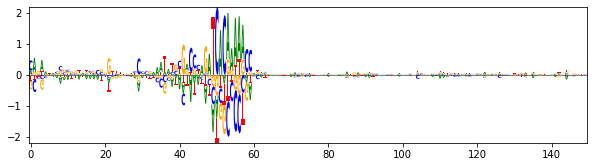

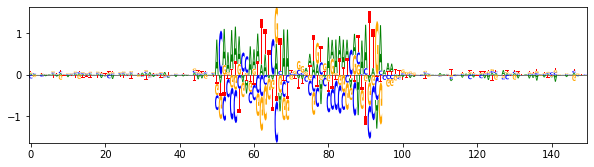

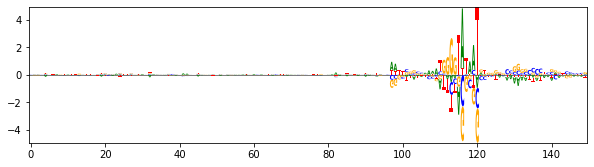

In [9]:
logomaker.Logo(-CRP_init_df,center_values=True)
logomaker.Logo(-xylR_init_df,center_values=True)
logomaker.Logo(-RNAP_init_df,center_values=True)

In [10]:
from mavenn.src.layers.gpmap import GPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(GPMapLayer):
    """Represents an thermodynamic model of transcription
       regulation in E. Coli at the xylE promoter, which 
       contains binding sites for RNAP, CRP, and xylR.
    """

    def __init__(self, 
                 CRP_start,
                 CRP_end,
                 xylR_start,
                 xylR_end,
                 RNAP_start,
                 RNAP_end,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.CRP_start = CRP_start
        self.CRP_end = CRP_end        

        self.xylR_start = xylR_start
        self.xylR_end = xylR_end                        
        
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end        
        
        # Create initializers
        self.CRP_init = CRP_init_df.iloc[CRP_start:CRP_end,:].values
        self.xylR_init = xylR_init_df.iloc[xylR_start:xylR_end,:].values
        self.RNAP_init = RNAP_init_df.iloc[RNAP_start:RNAP_end,:].values

        self.C=kwargs['C']
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        # form helpful variables
        self.L_CRP = CRP_end - CRP_start
        self.L_RNAP = RNAP_end - RNAP_start
        self.L_xylR = xylR_end - xylR_start
        
        super().__init__(*args, **kwargs)
        
        #1 define bias/chemical potential weight for crp
        self.mu_CRP = self.add_weight(name='mu_CRP',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)
        
        
        #2 define bias/chemical potential weight for xylR
        self.mu_xylR = self.add_weight(name='mu_xylR',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)                   

        #3 define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(name='mu_RNAP',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)
     
        

        #4 Define theta_CRP_lc parameters
        theta_CRP_lc_shape = (1, self.L_CRP, self.C)

        #theta_CRP_lc_init = np.random.randn(*theta_CRP_lc_shape)/np.sqrt(self.L_CRP)
        self.theta_CRP_lc = self.add_weight(name='theta_CRP_lc',
                                        shape=theta_CRP_lc_shape,
                                        initializer=Constant(self.CRP_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

                
        #5 Define theta_xylR_lc parameters
        theta_xylR_lc_shape = (1, self.L_xylR, self.C)

        #theta_xylR_lc_init = np.random.randn(*theta_xylR_lc_shape)/np.sqrt(self.L_xylR)
        self.theta_xylR_lc = self.add_weight(name='theta_xylR_lc',
                                        shape=theta_xylR_lc_shape,
                                        initializer=Constant(self.xylR_init),
                                        trainable=True,
                                        regularizer=self.regularizer)        
        
        #6 Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        #theta_RNAP_lc_init = np.random.randn(*theta_RNAP_lc_shape)/np.sqrt(self.L_RNAP)
        self.theta_RNAP_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_RNAP_lc_shape,
                                        initializer=Constant(self.RNAP_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        
        #7 define interaction term between CRP and xylR
        self.I_cx = self.add_weight(name='I_cx',
                               shape=(1,),
                               initializer=Constant(-1),
                               trainable=True)
        
        #8 define interaction term between RNAP and xylR. 
        self.I_rx = self.add_weight(name='I_rx',
                               shape=(1,),
                               initializer=Constant(-1),
                               trainable=True,
                               regularizer=self.regularizer)
        
#         #9 define interaction term between CRP and RNAP
#         self.I_cr = self.add_weight(name='I_cr',
#                                shape=(1,),
#                                initializer=Constant(-1),
#                                trainable=True)        
        
#         #10 define tsat term. 
        self.tsat = self.add_weight(name='tsat',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=False)        
        
#         # Call superclass build
        
#     def build(self, input_shape):
#         super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # extract locations of binding sites from entire lac-promoter sequence.
        x_CRP_lc = x_lc[:,self.C * self.CRP_start:self.C * self.CRP_end]
        x_xylR_lc = x_lc[:,self.C * self.xylR_start: self.C * self.xylR_end]
        x_RNAP_lc = x_lc[:,self.C * self.RNAP_start: self.C * self.RNAP_end]
        
        # reshape according to crp and rnap lengths. 
        x_CRP_lc = tf.reshape(x_CRP_lc, [-1, self.L_CRP, self.C])
        x_xylR_lc = tf.reshape(x_xylR_lc, [-1, self.L_xylR, self.C])        
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])

                
        # compute delta G for crp    
        phi_CRP = self.mu_CRP + \
              tf.reshape(K.sum(self.theta_CRP_lc * x_CRP_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for LacI
        phi_xylR = self.mu_xylR + \
              tf.reshape(K.sum(self.theta_xylR_lc * x_xylR_lc, axis=[1, 2]),
                         shape=[-1, 1])                             
            
        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + \
              tf.reshape(K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]),
                         shape=[-1, 1])                   
        
        # partition function
        Z = (1+K.exp(-phi_CRP)+K.exp(-phi_xylR)+ \
             K.exp(-phi_RNAP)+ \
             K.exp(-phi_xylR-phi_RNAP-self.I_rx)+ \
             #K.exp(-phi_CRP-phi_RNAP-self.I_cr)+ \
             K.exp(-phi_CRP-phi_RNAP)+ \
             K.exp(-phi_CRP-phi_xylR-phi_RNAP-self.I_cx-self.I_rx) +\
             K.exp(-phi_CRP-phi_xylR-self.I_cx)
            )
        
        transcription_states =  K.exp(-phi_RNAP)+ \
                                K.exp(-phi_xylR-phi_RNAP-self.I_rx)+ \
                                K.exp(-phi_CRP-phi_RNAP)+ \
                                K.exp(-phi_CRP-phi_xylR-phi_RNAP-self.I_cx-self.I_rx)
        
        
        
        # compute rate of transcription
        t = (self.tsat)*(transcription_states)/Z
        
        
        # return rate of transcription
        return t


The following are the number of different models I trained on my local machine, with roughly the same results

In [11]:
!ls 21.12.25.xylE_models

xylE_updated_dataset_0_lr_.001_bs_250_no_es.h5
xylE_updated_dataset_0_lr_.001_bs_250_no_es.pickle
xylE_updated_dataset_1_lr_.001_bs_250_no_es.h5
xylE_updated_dataset_1_lr_.001_bs_250_no_es.pickle
xylE_updated_dataset_2_lr_.001_bs_250_no_es.h5
xylE_updated_dataset_2_lr_.001_bs_250_no_es.pickle


In [12]:
model_dir = '21.12.27_xylE_models_jbk'
!rm -rf $model_dir
!mkdir $model_dir

In [13]:
# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='MPA', 
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               verbose=False,
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          verbose=False,
          try_tqdm=True,
          batch_size=1000,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=False)

model_file = f'{model_dir}/xylE'
model.save(model_file)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 34)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 34)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0epoch [00:00, ?epoch/s]

Training time: 3088.3 seconds
Model saved to these files:
	21.12.27_xylE_models_jbk/xylE.pickle
	21.12.27_xylE_models_jbk/xylE.h5


In [14]:
model = mavenn.load(model_file)

Model loaded from these files:
	21.12.27_xylE_models_jbk/xylE.pickle
	21.12.27_xylE_models_jbk/xylE.h5


In [15]:
# Subsample indices for easy plotting and information estimation
N_subsampled_test = len(test_df)
ix_test = np.random.rand(N_subsampled_test) < .2

# Get x and y
x_test = test_df['x'][ix_test]
y_test = test_df[y_cols][ix_test]

In [16]:
x_test.shape

(73974,)

On test data:
I_var_test: 1.589 +- 0.002 bits
I_pred_test: 1.671 +- 0.002 bits


Text(0.5, 1.0, 'training hisotry')

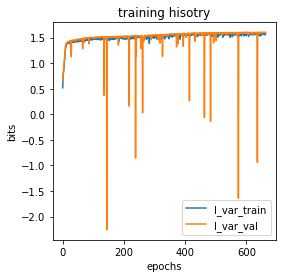

In [17]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

# I_var_test: 1.488 +- 0.001 bits
# I_pred_test: 1.692 +- 0.001 bits

In [18]:
model.get_nn().layers[2].I_rx.numpy()[0]

-4.7853045

In [19]:
interaction_term = model.get_nn().layers[2].get_weights()[4]
crp_weights = np.squeeze(model.get_nn().layers[2].theta_CRP_lc.numpy())
xylR_weights = np.squeeze(model.get_nn().layers[2].theta_xylR_lc.numpy())
rnap_weights = np.squeeze(model.get_nn().layers[2].theta_RNAP_lc.numpy())

I_cx = model.get_nn().layers[2].I_cx.numpy()[0]
I_rx = model.get_nn().layers[2].I_rx.numpy()[0]
#print(f'interaction term = {interaction_term[0]:.3f} k_bT')

In [20]:
# -1.954364, -2.5270987
# -1.9444253, -2.5044086
I_cx*0.62, I_rx*0.62

(-1.591986951828003, -2.966888818740845)

In [21]:
crp_df = pd.DataFrame(crp_weights,columns=model.alphabet)
xylR_df = pd.DataFrame(xylR_weights,columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights,columns=model.alphabet)

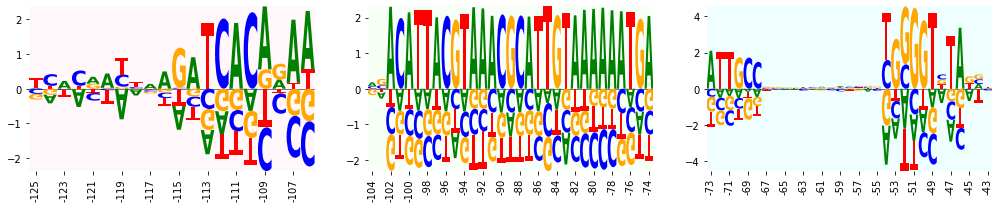

In [22]:
# # Get G-P map parameters in matrix form
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[14,3])

tick_spacing=2
crp_logo  = logomaker.Logo(-crp_df,ax=axs[0],center_values=True)
crp_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
crp_logo.style_spines(visible=False)
crp_logo.highlight_position_range(0,21,alpha=0.5,color='lavenderblush',label='CRP')
#crp_logo.style_glyphs_in_sequence(sequence='.TGTGA......TCACA...', color='darkred')
crp_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-125,-107+1,tick_spacing))

xylR_logo = logomaker.Logo(-xylR_df,ax=axs[1],center_values=True)
xylR_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
xylR_logo.style_spines(visible=False)
xylR_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-104,-74+1,tick_spacing))
xylR_logo.highlight_position_range(0,31,alpha=0.5,color='honeydew',label='RNAP')

rnap_logo = logomaker.Logo(-rnap_df,ax=axs[2],center_values=True)
rnap_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
rnap_logo.style_spines(visible=False)
rnap_logo.highlight_position_range(0,31,alpha=0.5,color='lightcyan',label='RNAP')
rnap_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-73,-42+1,tick_spacing))

# # # Right panel: draw measurement process as heatmap
# ax = axs[3]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_xylE.pdf',bbox_index='tight',dpi=500)
# plt.show()